In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Tavares2017_prep.csv')

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(30464, 4) (30464, 4)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 1s 617ms/step - loss: 164564.1406
Epoch 2/4000
1/1 [==============================] - 0s 11ms/step - loss: 163822.7344
Epoch 3/4000
1/1 [==============================] - 0s 45ms/step - loss: 163283.7812
Epoch 4/4000
1/1 [==============================] - 0s 10ms/step - loss: 162829.5938
Epoch 5/4000
1/1 [==============================] - 0s 8ms/step - loss: 162424.6406
Epoch 6/4000
1/1 [==============================] - 0s 7ms/step - loss: 162052.6562
Epoch 7/4000
1/1 [==============================] - 0s 7ms/step - loss: 161704.6719
Epoch 8/4000
1/1 [==============================] - 0s 8ms/step - loss: 161375.2344
Epoch 9/4000
1/1 [==============================] - 0s 7ms/step - loss: 161060.5000
Epoch 10/4000
1/1 [==============================] - 0s 8ms/step - loss: 160757.9531
Epoch 11/4000
1/1 [==============================] - 0s 7ms/step - loss: 160465.5938
Epoch 12/4000
1/1 [==============================] - 0s 8ms/step - lo

1/1 [==============================] - 0s 7ms/step - loss: 143521.7031
Epoch 98/4000
1/1 [==============================] - 0s 7ms/step - loss: 143367.0625
Epoch 99/4000
1/1 [==============================] - 0s 8ms/step - loss: 143213.1562
Epoch 100/4000
1/1 [==============================] - 0s 9ms/step - loss: 143059.9688
Epoch 101/4000
1/1 [==============================] - 0s 8ms/step - loss: 142907.5156
Epoch 102/4000
1/1 [==============================] - 0s 9ms/step - loss: 142755.7969
Epoch 103/4000
1/1 [==============================] - 0s 8ms/step - loss: 142604.7656
Epoch 104/4000
1/1 [==============================] - 0s 10ms/step - loss: 142454.5000
Epoch 105/4000
1/1 [==============================] - 0s 8ms/step - loss: 142304.9062
Epoch 106/4000
1/1 [==============================] - 0s 10ms/step - loss: 142156.0312
Epoch 107/4000
1/1 [==============================] - 0s 9ms/step - loss: 142007.8750
Epoch 108/4000
1/1 [==============================] - 0s 9ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 131551.2188
Epoch 193/4000
1/1 [==============================] - 0s 9ms/step - loss: 131448.1250
Epoch 194/4000
1/1 [==============================] - 0s 8ms/step - loss: 131345.3750
Epoch 195/4000
1/1 [==============================] - 0s 8ms/step - loss: 131242.9531
Epoch 196/4000
1/1 [==============================] - 0s 8ms/step - loss: 131140.8750
Epoch 197/4000
1/1 [==============================] - 0s 8ms/step - loss: 131039.1094
Epoch 198/4000
1/1 [==============================] - 0s 8ms/step - loss: 130937.6719
Epoch 199/4000
1/1 [==============================] - 0s 8ms/step - loss: 130836.5469
Epoch 200/4000
1/1 [==============================] - 0s 8ms/step - loss: 130735.7422
Epoch 201/4000
1/1 [==============================] - 0s 8ms/step - loss: 130635.2188
Epoch 202/4000
1/1 [==============================] - 0s 8ms/step - loss: 130535.0156
Epoch 203/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 122382.4766
Epoch 288/4000
1/1 [==============================] - 0s 8ms/step - loss: 122288.2031
Epoch 289/4000
1/1 [==============================] - 0s 8ms/step - loss: 122193.9609
Epoch 290/4000
1/1 [==============================] - 0s 8ms/step - loss: 122099.7344
Epoch 291/4000
1/1 [==============================] - 0s 8ms/step - loss: 122005.5625
Epoch 292/4000
1/1 [==============================] - 0s 8ms/step - loss: 121911.3828
Epoch 293/4000
1/1 [==============================] - 0s 8ms/step - loss: 121817.2578
Epoch 294/4000
1/1 [==============================] - 0s 8ms/step - loss: 121723.1406
Epoch 295/4000
1/1 [==============================] - 0s 8ms/step - loss: 121629.0625
Epoch 296/4000
1/1 [==============================] - 0s 8ms/step - loss: 121535.0156
Epoch 297/4000
1/1 [==============================] - 0s 8ms/step - loss: 121440.9922
Epoch 298/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 113706.0938
Epoch 383/4000
1/1 [==============================] - 0s 9ms/step - loss: 113621.2734
Epoch 384/4000
1/1 [==============================] - 0s 8ms/step - loss: 113536.6016
Epoch 385/4000
1/1 [==============================] - 0s 9ms/step - loss: 113452.1094
Epoch 386/4000
1/1 [==============================] - 0s 9ms/step - loss: 113367.7578
Epoch 387/4000
1/1 [==============================] - 0s 9ms/step - loss: 113283.5859
Epoch 388/4000
1/1 [==============================] - 0s 8ms/step - loss: 113199.5469
Epoch 389/4000
1/1 [==============================] - 0s 10ms/step - loss: 113115.6875
Epoch 390/4000
1/1 [==============================] - 0s 9ms/step - loss: 113031.9688
Epoch 391/4000
1/1 [==============================] - 0s 8ms/step - loss: 112948.3984
Epoch 392/4000
1/1 [==============================] - 0s 8ms/step - loss: 112864.9844
Epoch 393/4000
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 106275.4375
Epoch 478/4000
1/1 [==============================] - 0s 8ms/step - loss: 106203.4375
Epoch 479/4000
1/1 [==============================] - 0s 9ms/step - loss: 106131.3281
Epoch 480/4000
1/1 [==============================] - 0s 9ms/step - loss: 106059.5781
Epoch 481/4000
1/1 [==============================] - 0s 8ms/step - loss: 105987.7031
Epoch 482/4000
1/1 [==============================] - 0s 8ms/step - loss: 105916.1875
Epoch 483/4000
1/1 [==============================] - 0s 9ms/step - loss: 105844.5625
Epoch 484/4000
1/1 [==============================] - 0s 9ms/step - loss: 105773.2578
Epoch 485/4000
1/1 [==============================] - 0s 8ms/step - loss: 105701.8594
Epoch 486/4000
1/1 [==============================] - 0s 8ms/step - loss: 105630.8125
Epoch 487/4000
1/1 [==============================] - 0s 8ms/step - loss: 105559.6250
Epoch 488/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 99946.9375
Epoch 573/4000
1/1 [==============================] - 0s 8ms/step - loss: 99885.5781
Epoch 574/4000
1/1 [==============================] - 0s 8ms/step - loss: 99824.6797
Epoch 575/4000
1/1 [==============================] - 0s 8ms/step - loss: 99763.5312
Epoch 576/4000
1/1 [==============================] - 0s 8ms/step - loss: 99702.8281
Epoch 577/4000
1/1 [==============================] - 0s 8ms/step - loss: 99641.8828
Epoch 578/4000
1/1 [==============================] - 0s 8ms/step - loss: 99581.4062
Epoch 579/4000
1/1 [==============================] - 0s 8ms/step - loss: 99520.6562
Epoch 580/4000
1/1 [==============================] - 0s 8ms/step - loss: 99460.3672
Epoch 581/4000
1/1 [==============================] - 0s 8ms/step - loss: 99399.8203
Epoch 582/4000
1/1 [==============================] - 0s 8ms/step - loss: 99339.7344
Epoch 583/4000
1/1 [==============================] - 0s 8ms/step - loss: 99279.

1/1 [==============================] - 0s 7ms/step - loss: 94498.9062
Epoch 669/4000
1/1 [==============================] - 0s 8ms/step - loss: 94446.2031
Epoch 670/4000
1/1 [==============================] - 0s 8ms/step - loss: 94394.0625
Epoch 671/4000
1/1 [==============================] - 0s 8ms/step - loss: 94341.5312
Epoch 672/4000
1/1 [==============================] - 0s 8ms/step - loss: 94289.5625
Epoch 673/4000
1/1 [==============================] - 0s 7ms/step - loss: 94237.2031
Epoch 674/4000
1/1 [==============================] - 0s 8ms/step - loss: 94185.4219
Epoch 675/4000
1/1 [==============================] - 0s 8ms/step - loss: 94133.2344
Epoch 676/4000
1/1 [==============================] - 0s 8ms/step - loss: 94081.6406
Epoch 677/4000
1/1 [==============================] - 0s 8ms/step - loss: 94029.6250
Epoch 678/4000
1/1 [==============================] - 0s 8ms/step - loss: 93978.2188
Epoch 679/4000
1/1 [==============================] - 0s 8ms/step - loss: 93926.

1/1 [==============================] - 0s 10ms/step - loss: 89873.1953
Epoch 765/4000
1/1 [==============================] - 0s 10ms/step - loss: 89829.0156
Epoch 766/4000
1/1 [==============================] - 0s 9ms/step - loss: 89785.5234
Epoch 767/4000
1/1 [==============================] - 0s 10ms/step - loss: 89741.5078
Epoch 768/4000
1/1 [==============================] - 0s 10ms/step - loss: 89698.1719
Epoch 769/4000
1/1 [==============================] - 0s 8ms/step - loss: 89654.3281
Epoch 770/4000
1/1 [==============================] - 0s 10ms/step - loss: 89611.1719
Epoch 771/4000
1/1 [==============================] - 0s 10ms/step - loss: 89567.4844
Epoch 772/4000
1/1 [==============================] - 0s 9ms/step - loss: 89524.5078
Epoch 773/4000
1/1 [==============================] - 0s 9ms/step - loss: 89481.0000
Epoch 774/4000
1/1 [==============================] - 0s 10ms/step - loss: 89438.1797
Epoch 775/4000
1/1 [==============================] - 0s 10ms/step - loss

1/1 [==============================] - 0s 11ms/step - loss: 86032.4062
Epoch 861/4000
1/1 [==============================] - 0s 9ms/step - loss: 85996.0312
Epoch 862/4000
1/1 [==============================] - 0s 10ms/step - loss: 85960.2891
Epoch 863/4000
1/1 [==============================] - 0s 10ms/step - loss: 85924.0703
Epoch 864/4000
1/1 [==============================] - 0s 9ms/step - loss: 85888.5078
Epoch 865/4000
1/1 [==============================] - 0s 10ms/step - loss: 85852.4609
Epoch 866/4000
1/1 [==============================] - 0s 10ms/step - loss: 85817.0625
Epoch 867/4000
1/1 [==============================] - 0s 9ms/step - loss: 85781.2031
Epoch 868/4000
1/1 [==============================] - 0s 11ms/step - loss: 85745.9688
Epoch 869/4000
1/1 [==============================] - 0s 10ms/step - loss: 85710.2734
Epoch 870/4000
1/1 [==============================] - 0s 9ms/step - loss: 85675.2031
Epoch 871/4000
1/1 [==============================] - 0s 11ms/step - loss

1/1 [==============================] - 0s 8ms/step - loss: 82959.7656
Epoch 957/4000
1/1 [==============================] - 0s 8ms/step - loss: 82931.8750
Epoch 958/4000
1/1 [==============================] - 0s 9ms/step - loss: 82904.0000
Epoch 959/4000
1/1 [==============================] - 0s 8ms/step - loss: 82876.3281
Epoch 960/4000
1/1 [==============================] - 0s 8ms/step - loss: 82848.6406
Epoch 961/4000
1/1 [==============================] - 0s 8ms/step - loss: 82821.0938
Epoch 962/4000
1/1 [==============================] - 0s 13ms/step - loss: 82793.5156
Epoch 963/4000
1/1 [==============================] - 0s 11ms/step - loss: 82766.1094
Epoch 964/4000
1/1 [==============================] - 0s 8ms/step - loss: 82738.6562
Epoch 965/4000
1/1 [==============================] - 0s 8ms/step - loss: 82711.3750
Epoch 966/4000
1/1 [==============================] - 0s 8ms/step - loss: 82684.0469
Epoch 967/4000
1/1 [==============================] - 0s 8ms/step - loss: 8265

1/1 [==============================] - 0s 11ms/step - loss: 80645.0234
Epoch 1052/4000
1/1 [==============================] - 0s 9ms/step - loss: 80623.6172
Epoch 1053/4000
1/1 [==============================] - 0s 10ms/step - loss: 80603.0781
Epoch 1054/4000
1/1 [==============================] - 0s 9ms/step - loss: 80581.7812
Epoch 1055/4000
1/1 [==============================] - 0s 9ms/step - loss: 80561.5391
Epoch 1056/4000
1/1 [==============================] - 0s 10ms/step - loss: 80540.3828
Epoch 1057/4000
1/1 [==============================] - 0s 9ms/step - loss: 80520.4922
Epoch 1058/4000
1/1 [==============================] - 0s 11ms/step - loss: 80499.3125
Epoch 1059/4000
1/1 [==============================] - 0s 9ms/step - loss: 80479.3750
Epoch 1060/4000
1/1 [==============================] - 0s 9ms/step - loss: 80458.2969
Epoch 1061/4000
1/1 [==============================] - 0s 10ms/step - loss: 80438.5469
Epoch 1062/4000
1/1 [==============================] - 0s 9ms/ste

1/1 [==============================] - 0s 8ms/step - loss: 78917.5938
Epoch 1147/4000
1/1 [==============================] - 0s 8ms/step - loss: 78902.7344
Epoch 1148/4000
1/1 [==============================] - 0s 8ms/step - loss: 78886.2422
Epoch 1149/4000
1/1 [==============================] - 0s 8ms/step - loss: 78871.5078
Epoch 1150/4000
1/1 [==============================] - 0s 8ms/step - loss: 78855.1484
Epoch 1151/4000
1/1 [==============================] - 0s 8ms/step - loss: 78840.5312
Epoch 1152/4000
1/1 [==============================] - 0s 8ms/step - loss: 78824.1250
Epoch 1153/4000
1/1 [==============================] - 0s 8ms/step - loss: 78809.6562
Epoch 1154/4000
1/1 [==============================] - 0s 8ms/step - loss: 78793.4062
Epoch 1155/4000
1/1 [==============================] - 0s 8ms/step - loss: 78778.9609
Epoch 1156/4000
1/1 [==============================] - 0s 8ms/step - loss: 78762.7969
Epoch 1157/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 77602.8750
Epoch 1242/4000
1/1 [==============================] - 0s 8ms/step - loss: 77589.5625
Epoch 1243/4000
1/1 [==============================] - 0s 7ms/step - loss: 77578.2109
Epoch 1244/4000
1/1 [==============================] - 0s 8ms/step - loss: 77564.8750
Epoch 1245/4000
1/1 [==============================] - 0s 8ms/step - loss: 77553.6406
Epoch 1246/4000
1/1 [==============================] - 0s 8ms/step - loss: 77540.5312
Epoch 1247/4000
1/1 [==============================] - 0s 8ms/step - loss: 77529.2500
Epoch 1248/4000
1/1 [==============================] - 0s 8ms/step - loss: 77516.0234
Epoch 1249/4000
1/1 [==============================] - 0s 9ms/step - loss: 77504.7500
Epoch 1250/4000
1/1 [==============================] - 0s 8ms/step - loss: 77491.6250
Epoch 1251/4000
1/1 [==============================] - 0s 8ms/step - loss: 77480.4219
Epoch 1252/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 76549.7969
Epoch 1337/4000
1/1 [==============================] - 0s 8ms/step - loss: 76541.2891
Epoch 1338/4000
1/1 [==============================] - 0s 8ms/step - loss: 76530.7109
Epoch 1339/4000
1/1 [==============================] - 0s 8ms/step - loss: 76522.5859
Epoch 1340/4000
1/1 [==============================] - 0s 8ms/step - loss: 76512.1875
Epoch 1341/4000
1/1 [==============================] - 0s 7ms/step - loss: 76504.2031
Epoch 1342/4000
1/1 [==============================] - 0s 8ms/step - loss: 76493.8438
Epoch 1343/4000
1/1 [==============================] - 0s 8ms/step - loss: 76485.8281
Epoch 1344/4000
1/1 [==============================] - 0s 8ms/step - loss: 76475.6875
Epoch 1345/4000
1/1 [==============================] - 0s 8ms/step - loss: 76467.7344
Epoch 1346/4000
1/1 [==============================] - 0s 8ms/step - loss: 76457.6016
Epoch 1347/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 75882.8203
Epoch 1432/4000
1/1 [==============================] - 0s 8ms/step - loss: 75825.2031
Epoch 1433/4000
1/1 [==============================] - 0s 7ms/step - loss: 75819.4844
Epoch 1434/4000
1/1 [==============================] - 0s 8ms/step - loss: 75812.3828
Epoch 1435/4000
1/1 [==============================] - 0s 8ms/step - loss: 75808.2656
Epoch 1436/4000
1/1 [==============================] - 0s 8ms/step - loss: 75798.7812
Epoch 1437/4000
1/1 [==============================] - 0s 8ms/step - loss: 75793.1094
Epoch 1438/4000
1/1 [==============================] - 0s 8ms/step - loss: 75787.4688
Epoch 1439/4000
1/1 [==============================] - 0s 7ms/step - loss: 75783.4141
Epoch 1440/4000
1/1 [==============================] - 0s 8ms/step - loss: 75775.7344
Epoch 1441/4000
1/1 [==============================] - 0s 8ms/step - loss: 75772.1094
Epoch 1442/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 75347.6719
Epoch 1527/4000
1/1 [==============================] - 0s 8ms/step - loss: 75345.1562
Epoch 1528/4000
1/1 [==============================] - 0s 8ms/step - loss: 75342.3125
Epoch 1529/4000
1/1 [==============================] - 0s 9ms/step - loss: 75339.7266
Epoch 1530/4000
1/1 [==============================] - 0s 8ms/step - loss: 75338.4297
Epoch 1531/4000
1/1 [==============================] - 0s 8ms/step - loss: 75387.1406
Epoch 1532/4000
1/1 [==============================] - 0s 9ms/step - loss: 75331.8828
Epoch 1533/4000
1/1 [==============================] - 0s 8ms/step - loss: 75323.6641
Epoch 1534/4000
1/1 [==============================] - 0s 9ms/step - loss: 75317.0312
Epoch 1535/4000
1/1 [==============================] - 0s 8ms/step - loss: 75316.8125
Epoch 1536/4000
1/1 [==============================] - 0s 9ms/step - loss: 75326.1797
Epoch 1537/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 75013.7031
Epoch 1622/4000
1/1 [==============================] - 0s 8ms/step - loss: 75014.4297
Epoch 1623/4000
1/1 [==============================] - 0s 8ms/step - loss: 75025.8281
Epoch 1624/4000
1/1 [==============================] - 0s 8ms/step - loss: 75011.3516
Epoch 1625/4000
1/1 [==============================] - 0s 8ms/step - loss: 75046.7422
Epoch 1626/4000
1/1 [==============================] - 0s 8ms/step - loss: 74988.5859
Epoch 1627/4000
1/1 [==============================] - 0s 8ms/step - loss: 74985.6172
Epoch 1628/4000
1/1 [==============================] - 0s 8ms/step - loss: 74980.3438
Epoch 1629/4000
1/1 [==============================] - 0s 8ms/step - loss: 74969.5312
Epoch 1630/4000
1/1 [==============================] - 0s 8ms/step - loss: 74966.5156
Epoch 1631/4000
1/1 [==============================] - 0s 8ms/step - loss: 74961.8828
Epoch 1632/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 74739.1953
Epoch 1717/4000
1/1 [==============================] - 0s 8ms/step - loss: 74746.7812
Epoch 1718/4000
1/1 [==============================] - 0s 8ms/step - loss: 74761.6016
Epoch 1719/4000
1/1 [==============================] - 0s 9ms/step - loss: 74807.1172
Epoch 1720/4000
1/1 [==============================] - 0s 8ms/step - loss: 74799.3750
Epoch 1721/4000
1/1 [==============================] - 0s 7ms/step - loss: 74745.3438
Epoch 1722/4000
1/1 [==============================] - 0s 8ms/step - loss: 74743.6875
Epoch 1723/4000
1/1 [==============================] - 0s 8ms/step - loss: 74740.3125
Epoch 1724/4000
1/1 [==============================] - 0s 8ms/step - loss: 74782.0625
Epoch 1725/4000
1/1 [==============================] - 0s 8ms/step - loss: 74782.7266
Epoch 1726/4000
1/1 [==============================] - 0s 8ms/step - loss: 74766.1719
Epoch 1727/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 12ms/step - loss: 74540.2031
Epoch 1812/4000
1/1 [==============================] - 0s 8ms/step - loss: 74535.0625
Epoch 1813/4000
1/1 [==============================] - 0s 8ms/step - loss: 74529.4922
Epoch 1814/4000
1/1 [==============================] - 0s 8ms/step - loss: 74527.6875
Epoch 1815/4000
1/1 [==============================] - 0s 8ms/step - loss: 74530.7891
Epoch 1816/4000
1/1 [==============================] - 0s 8ms/step - loss: 74527.1953
Epoch 1817/4000
1/1 [==============================] - 0s 8ms/step - loss: 74570.0156
Epoch 1818/4000
1/1 [==============================] - 0s 8ms/step - loss: 74524.0000
Epoch 1819/4000
1/1 [==============================] - 0s 8ms/step - loss: 74591.7578
Epoch 1820/4000
1/1 [==============================] - 0s 8ms/step - loss: 74629.6953
Epoch 1821/4000
1/1 [==============================] - 0s 8ms/step - loss: 74636.6172
Epoch 1822/4000
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 74403.1172
Epoch 1907/4000
1/1 [==============================] - 0s 8ms/step - loss: 74404.9219
Epoch 1908/4000
1/1 [==============================] - 0s 8ms/step - loss: 74400.4453
Epoch 1909/4000
1/1 [==============================] - 0s 8ms/step - loss: 74399.6250
Epoch 1910/4000
1/1 [==============================] - 0s 8ms/step - loss: 74396.5312
Epoch 1911/4000
1/1 [==============================] - 0s 9ms/step - loss: 74396.2109
Epoch 1912/4000
1/1 [==============================] - 0s 8ms/step - loss: 74385.9062
Epoch 1913/4000
1/1 [==============================] - 0s 8ms/step - loss: 74387.2969
Epoch 1914/4000
1/1 [==============================] - 0s 8ms/step - loss: 74376.2266
Epoch 1915/4000
1/1 [==============================] - 0s 8ms/step - loss: 74380.2969
Epoch 1916/4000
1/1 [==============================] - 0s 9ms/step - loss: 74384.0469
Epoch 1917/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 74315.5156
Epoch 2002/4000
1/1 [==============================] - 0s 8ms/step - loss: 74262.0859
Epoch 2003/4000
1/1 [==============================] - 0s 8ms/step - loss: 74264.3125
Epoch 2004/4000
1/1 [==============================] - 0s 8ms/step - loss: 74265.2969
Epoch 2005/4000
1/1 [==============================] - 0s 8ms/step - loss: 74259.4062
Epoch 2006/4000
1/1 [==============================] - 0s 8ms/step - loss: 74256.8750
Epoch 2007/4000
1/1 [==============================] - 0s 8ms/step - loss: 74256.5156
Epoch 2008/4000
1/1 [==============================] - 0s 8ms/step - loss: 74256.6484
Epoch 2009/4000
1/1 [==============================] - 0s 8ms/step - loss: 74253.1094
Epoch 2010/4000
1/1 [==============================] - 0s 8ms/step - loss: 74250.7969
Epoch 2011/4000
1/1 [==============================] - 0s 8ms/step - loss: 74252.4219
Epoch 2012/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 74156.7266
Epoch 2097/4000
1/1 [==============================] - 0s 8ms/step - loss: 74153.7891
Epoch 2098/4000
1/1 [==============================] - 0s 8ms/step - loss: 74148.8984
Epoch 2099/4000
1/1 [==============================] - 0s 8ms/step - loss: 74146.4375
Epoch 2100/4000
1/1 [==============================] - 0s 7ms/step - loss: 74142.3828
Epoch 2101/4000
1/1 [==============================] - 0s 8ms/step - loss: 74139.3281
Epoch 2102/4000
1/1 [==============================] - 0s 8ms/step - loss: 74137.2969
Epoch 2103/4000
1/1 [==============================] - 0s 8ms/step - loss: 74185.3438
Epoch 2104/4000
1/1 [==============================] - 0s 8ms/step - loss: 74134.8516
Epoch 2105/4000
1/1 [==============================] - 0s 9ms/step - loss: 74136.1016
Epoch 2106/4000
1/1 [==============================] - 0s 8ms/step - loss: 74141.0938
Epoch 2107/4000
1/1 [==============================] - 0s 9ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 74058.8906
Epoch 2192/4000
1/1 [==============================] - 0s 8ms/step - loss: 74097.6406
Epoch 2193/4000
1/1 [==============================] - 0s 8ms/step - loss: 74044.2266
Epoch 2194/4000
1/1 [==============================] - 0s 8ms/step - loss: 74041.4688
Epoch 2195/4000
1/1 [==============================] - 0s 8ms/step - loss: 74036.3672
Epoch 2196/4000
1/1 [==============================] - 0s 8ms/step - loss: 74034.8281
Epoch 2197/4000
1/1 [==============================] - 0s 8ms/step - loss: 74083.2500
Epoch 2198/4000
1/1 [==============================] - 0s 8ms/step - loss: 74035.6797
Epoch 2199/4000
1/1 [==============================] - 0s 8ms/step - loss: 74037.1094
Epoch 2200/4000
1/1 [==============================] - 0s 7ms/step - loss: 74043.0234
Epoch 2201/4000
1/1 [==============================] - 0s 8ms/step - loss: 74054.0469
Epoch 2202/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 74054.9375
Epoch 2287/4000
1/1 [==============================] - 0s 8ms/step - loss: 74055.3359
Epoch 2288/4000
1/1 [==============================] - 0s 8ms/step - loss: 73990.4375
Epoch 2289/4000
1/1 [==============================] - 0s 8ms/step - loss: 73976.7266
Epoch 2290/4000
1/1 [==============================] - 0s 8ms/step - loss: 73959.3438
Epoch 2291/4000
1/1 [==============================] - 0s 8ms/step - loss: 73954.5859
Epoch 2292/4000
1/1 [==============================] - 0s 9ms/step - loss: 73949.1328
Epoch 2293/4000
1/1 [==============================] - 0s 8ms/step - loss: 73940.9844
Epoch 2294/4000
1/1 [==============================] - 0s 8ms/step - loss: 73943.0156
Epoch 2295/4000
1/1 [==============================] - 0s 8ms/step - loss: 73946.6172
Epoch 2296/4000
1/1 [==============================] - 0s 8ms/step - loss: 73949.5156
Epoch 2297/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 73960.3438
Epoch 2382/4000
1/1 [==============================] - 0s 8ms/step - loss: 73897.7031
Epoch 2383/4000
1/1 [==============================] - 0s 8ms/step - loss: 73892.9297
Epoch 2384/4000
1/1 [==============================] - 0s 7ms/step - loss: 73889.3750
Epoch 2385/4000
1/1 [==============================] - 0s 8ms/step - loss: 73884.0625
Epoch 2386/4000
1/1 [==============================] - 0s 8ms/step - loss: 73884.9688
Epoch 2387/4000
1/1 [==============================] - 0s 8ms/step - loss: 73879.4922
Epoch 2388/4000
1/1 [==============================] - 0s 8ms/step - loss: 73888.6562
Epoch 2389/4000
1/1 [==============================] - 0s 7ms/step - loss: 73879.4844
Epoch 2390/4000
1/1 [==============================] - 0s 8ms/step - loss: 73883.0000
Epoch 2391/4000
1/1 [==============================] - 0s 7ms/step - loss: 73884.0469
Epoch 2392/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 73829.2188
Epoch 2477/4000
1/1 [==============================] - 0s 8ms/step - loss: 73864.5156
Epoch 2478/4000
1/1 [==============================] - 0s 8ms/step - loss: 73816.1719
Epoch 2479/4000
1/1 [==============================] - 0s 9ms/step - loss: 73814.1562
Epoch 2480/4000
1/1 [==============================] - 0s 8ms/step - loss: 73817.5938
Epoch 2481/4000
1/1 [==============================] - 0s 8ms/step - loss: 73865.8594
Epoch 2482/4000
1/1 [==============================] - 0s 8ms/step - loss: 73814.8281
Epoch 2483/4000
1/1 [==============================] - 0s 8ms/step - loss: 73912.1562
Epoch 2484/4000
1/1 [==============================] - 0s 7ms/step - loss: 73826.3750
Epoch 2485/4000
1/1 [==============================] - 0s 8ms/step - loss: 73891.9922
Epoch 2486/4000
1/1 [==============================] - 0s 8ms/step - loss: 73912.8672
Epoch 2487/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 73845.9297
Epoch 2572/4000
1/1 [==============================] - 0s 8ms/step - loss: 73816.1953
Epoch 2573/4000
1/1 [==============================] - 0s 8ms/step - loss: 73761.3438
Epoch 2574/4000
1/1 [==============================] - 0s 8ms/step - loss: 73853.8438
Epoch 2575/4000
1/1 [==============================] - 0s 8ms/step - loss: 73803.3516
Epoch 2576/4000
1/1 [==============================] - 0s 8ms/step - loss: 73758.9062
Epoch 2577/4000
1/1 [==============================] - 0s 8ms/step - loss: 73809.9062
Epoch 2578/4000
1/1 [==============================] - 0s 9ms/step - loss: 73762.8516
Epoch 2579/4000
1/1 [==============================] - 0s 8ms/step - loss: 73807.6172
Epoch 2580/4000
1/1 [==============================] - 0s 8ms/step - loss: 73855.7266
Epoch 2581/4000
1/1 [==============================] - 0s 8ms/step - loss: 73764.5078
Epoch 2582/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 73778.4297
Epoch 2667/4000
1/1 [==============================] - 0s 8ms/step - loss: 73785.4219
Epoch 2668/4000
1/1 [==============================] - 0s 7ms/step - loss: 73825.2344
Epoch 2669/4000
1/1 [==============================] - 0s 8ms/step - loss: 73759.0859
Epoch 2670/4000
1/1 [==============================] - 0s 8ms/step - loss: 73735.1719
Epoch 2671/4000
1/1 [==============================] - 0s 8ms/step - loss: 73727.3594
Epoch 2672/4000
1/1 [==============================] - 0s 8ms/step - loss: 73762.9531
Epoch 2673/4000
1/1 [==============================] - 0s 8ms/step - loss: 73764.8828
Epoch 2674/4000
1/1 [==============================] - 0s 8ms/step - loss: 73761.2188
Epoch 2675/4000
1/1 [==============================] - 0s 8ms/step - loss: 73719.8438
Epoch 2676/4000
1/1 [==============================] - 0s 8ms/step - loss: 73764.5469
Epoch 2677/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 73686.6562
Epoch 2762/4000
1/1 [==============================] - 0s 8ms/step - loss: 73728.3125
Epoch 2763/4000
1/1 [==============================] - 0s 9ms/step - loss: 73732.9219
Epoch 2764/4000
1/1 [==============================] - 0s 9ms/step - loss: 73732.4531
Epoch 2765/4000
1/1 [==============================] - 0s 8ms/step - loss: 73732.4297
Epoch 2766/4000
1/1 [==============================] - 0s 12ms/step - loss: 73688.0469
Epoch 2767/4000
1/1 [==============================] - 0s 9ms/step - loss: 73786.8750
Epoch 2768/4000
1/1 [==============================] - 0s 9ms/step - loss: 73711.9062
Epoch 2769/4000
1/1 [==============================] - 0s 8ms/step - loss: 73772.1562
Epoch 2770/4000
1/1 [==============================] - 0s 9ms/step - loss: 73877.0625
Epoch 2771/4000
1/1 [==============================] - 0s 9ms/step - loss: 73786.8125
Epoch 2772/4000
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 73673.3750
Epoch 2857/4000
1/1 [==============================] - 0s 9ms/step - loss: 73658.9688
Epoch 2858/4000
1/1 [==============================] - 0s 8ms/step - loss: 73659.3828
Epoch 2859/4000
1/1 [==============================] - 0s 10ms/step - loss: 73659.0859
Epoch 2860/4000
1/1 [==============================] - 0s 10ms/step - loss: 73656.4609
Epoch 2861/4000
1/1 [==============================] - 0s 8ms/step - loss: 73654.6797
Epoch 2862/4000
1/1 [==============================] - 0s 8ms/step - loss: 73656.7344
Epoch 2863/4000
1/1 [==============================] - 0s 8ms/step - loss: 73662.0781
Epoch 2864/4000
1/1 [==============================] - 0s 8ms/step - loss: 73673.8125
Epoch 2865/4000
1/1 [==============================] - 0s 8ms/step - loss: 73688.6172
Epoch 2866/4000
1/1 [==============================] - 0s 9ms/step - loss: 73697.9922
Epoch 2867/4000
1/1 [==============================] - 0s 9ms/step -

1/1 [==============================] - 0s 8ms/step - loss: 73615.0078
Epoch 2952/4000
1/1 [==============================] - 0s 8ms/step - loss: 73613.0078
Epoch 2953/4000
1/1 [==============================] - 0s 8ms/step - loss: 73620.9688
Epoch 2954/4000
1/1 [==============================] - 0s 8ms/step - loss: 73618.5547
Epoch 2955/4000
1/1 [==============================] - 0s 8ms/step - loss: 73620.5156
Epoch 2956/4000
1/1 [==============================] - 0s 8ms/step - loss: 73627.7031
Epoch 2957/4000
1/1 [==============================] - 0s 8ms/step - loss: 73630.0469
Epoch 2958/4000
1/1 [==============================] - 0s 8ms/step - loss: 73736.9062
Epoch 2959/4000
1/1 [==============================] - 0s 9ms/step - loss: 73680.7266
Epoch 2960/4000
1/1 [==============================] - 0s 8ms/step - loss: 73715.2188
Epoch 2961/4000
1/1 [==============================] - 0s 9ms/step - loss: 73645.8594
Epoch 2962/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 73605.6250
Epoch 3047/4000
1/1 [==============================] - 0s 7ms/step - loss: 73651.9375
Epoch 3048/4000
1/1 [==============================] - 0s 8ms/step - loss: 73647.9844
Epoch 3049/4000
1/1 [==============================] - 0s 8ms/step - loss: 73660.2109
Epoch 3050/4000
1/1 [==============================] - 0s 8ms/step - loss: 73623.2500
Epoch 3051/4000
1/1 [==============================] - 0s 8ms/step - loss: 73646.2031
Epoch 3052/4000
1/1 [==============================] - 0s 8ms/step - loss: 73643.4062
Epoch 3053/4000
1/1 [==============================] - 0s 8ms/step - loss: 73625.9375
Epoch 3054/4000
1/1 [==============================] - 0s 8ms/step - loss: 73663.4062
Epoch 3055/4000
1/1 [==============================] - 0s 7ms/step - loss: 73606.4688
Epoch 3056/4000
1/1 [==============================] - 0s 8ms/step - loss: 73595.8281
Epoch 3057/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 73657.1406
Epoch 3142/4000
1/1 [==============================] - 0s 8ms/step - loss: 73611.0312
Epoch 3143/4000
1/1 [==============================] - 0s 8ms/step - loss: 73605.8281
Epoch 3144/4000
1/1 [==============================] - 0s 8ms/step - loss: 73597.4062
Epoch 3145/4000
1/1 [==============================] - 0s 8ms/step - loss: 73585.9375
Epoch 3146/4000
1/1 [==============================] - 0s 9ms/step - loss: 73627.5312
Epoch 3147/4000
1/1 [==============================] - 0s 8ms/step - loss: 73574.9609
Epoch 3148/4000
1/1 [==============================] - 0s 8ms/step - loss: 73574.3438
Epoch 3149/4000
1/1 [==============================] - 0s 8ms/step - loss: 73575.1953
Epoch 3150/4000
1/1 [==============================] - 0s 8ms/step - loss: 73575.2656
Epoch 3151/4000
1/1 [==============================] - 0s 8ms/step - loss: 73581.5391
Epoch 3152/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 73600.2500
Epoch 3237/4000
1/1 [==============================] - 0s 9ms/step - loss: 73599.0156
Epoch 3238/4000
1/1 [==============================] - 0s 8ms/step - loss: 73592.7734
Epoch 3239/4000
1/1 [==============================] - 0s 8ms/step - loss: 73571.1484
Epoch 3240/4000
1/1 [==============================] - 0s 8ms/step - loss: 73599.4062
Epoch 3241/4000
1/1 [==============================] - 0s 8ms/step - loss: 73547.9922
Epoch 3242/4000
1/1 [==============================] - 0s 8ms/step - loss: 73546.2266
Epoch 3243/4000
1/1 [==============================] - 0s 8ms/step - loss: 73594.2734
Epoch 3244/4000
1/1 [==============================] - 0s 8ms/step - loss: 73591.2031
Epoch 3245/4000
1/1 [==============================] - 0s 8ms/step - loss: 73550.3281
Epoch 3246/4000
1/1 [==============================] - 0s 8ms/step - loss: 73570.7344
Epoch 3247/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 73582.1953
Epoch 3332/4000
1/1 [==============================] - 0s 8ms/step - loss: 73571.4922
Epoch 3333/4000
1/1 [==============================] - 0s 8ms/step - loss: 73553.3828
Epoch 3334/4000
1/1 [==============================] - 0s 8ms/step - loss: 73542.6406
Epoch 3335/4000
1/1 [==============================] - 0s 8ms/step - loss: 73534.4141
Epoch 3336/4000
1/1 [==============================] - 0s 8ms/step - loss: 73531.4922
Epoch 3337/4000
1/1 [==============================] - 0s 8ms/step - loss: 73580.5391
Epoch 3338/4000
1/1 [==============================] - 0s 8ms/step - loss: 73532.3828
Epoch 3339/4000
1/1 [==============================] - 0s 8ms/step - loss: 73534.0938
Epoch 3340/4000
1/1 [==============================] - 0s 9ms/step - loss: 73539.8438
Epoch 3341/4000
1/1 [==============================] - 0s 8ms/step - loss: 73591.8906
Epoch 3342/4000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 11ms/step - loss: 73525.8672
Epoch 3427/4000
1/1 [==============================] - 0s 10ms/step - loss: 73567.9297
Epoch 3428/4000
1/1 [==============================] - 0s 10ms/step - loss: 73574.1484
Epoch 3429/4000
1/1 [==============================] - 0s 11ms/step - loss: 73536.0469
Epoch 3430/4000
1/1 [==============================] - 0s 11ms/step - loss: 73540.1562
Epoch 3431/4000
1/1 [==============================] - 0s 10ms/step - loss: 73544.5938
Epoch 3432/4000
1/1 [==============================] - 0s 10ms/step - loss: 73555.8281
Epoch 3433/4000
1/1 [==============================] - 0s 10ms/step - loss: 73586.4844
Epoch 3434/4000
1/1 [==============================] - 0s 10ms/step - loss: 73582.5078
Epoch 3435/4000
1/1 [==============================] - 0s 11ms/step - loss: 73517.2500
Epoch 3436/4000
1/1 [==============================] - 0s 10ms/step - loss: 73525.2734
Epoch 3437/4000
1/1 [==============================] - 0s 1

Epoch 3521/4000
1/1 [==============================] - 0s 12ms/step - loss: 73511.0312
Epoch 3522/4000
1/1 [==============================] - 0s 11ms/step - loss: 73510.3594
Epoch 3523/4000
1/1 [==============================] - 0s 11ms/step - loss: 73499.6562
Epoch 3524/4000
1/1 [==============================] - 0s 11ms/step - loss: 73504.0078
Epoch 3525/4000
1/1 [==============================] - 0s 13ms/step - loss: 73499.3828
Epoch 3526/4000
1/1 [==============================] - 0s 12ms/step - loss: 73551.2109
Epoch 3527/4000
1/1 [==============================] - 0s 11ms/step - loss: 73501.5859
Epoch 3528/4000
1/1 [==============================] - 0s 11ms/step - loss: 73516.4766
Epoch 3529/4000
1/1 [==============================] - 0s 12ms/step - loss: 73567.9219
Epoch 3530/4000
1/1 [==============================] - 0s 12ms/step - loss: 73530.0234
Epoch 3531/4000
1/1 [==============================] - 0s 12ms/step - loss: 73574.9062
Epoch 3532/4000
1/1 [======================

1/1 [==============================] - 0s 8ms/step - loss: 73635.9219
Epoch 3616/4000
1/1 [==============================] - 0s 9ms/step - loss: 73586.7266
Epoch 3617/4000
1/1 [==============================] - 0s 9ms/step - loss: 73502.0469
Epoch 3618/4000
1/1 [==============================] - 0s 8ms/step - loss: 73487.2734
Epoch 3619/4000
1/1 [==============================] - 0s 9ms/step - loss: 73479.4141
Epoch 3620/4000
1/1 [==============================] - 0s 8ms/step - loss: 73476.2031
Epoch 3621/4000
1/1 [==============================] - 0s 8ms/step - loss: 73530.8594
Epoch 3622/4000
1/1 [==============================] - 0s 9ms/step - loss: 73478.4375
Epoch 3623/4000
1/1 [==============================] - 0s 10ms/step - loss: 73474.6016
Epoch 3624/4000
1/1 [==============================] - 0s 10ms/step - loss: 73477.5234
Epoch 3625/4000
1/1 [==============================] - 0s 10ms/step - loss: 73482.9375
Epoch 3626/4000
1/1 [==============================] - 0s 9ms/step 

1/1 [==============================] - 0s 9ms/step - loss: 73470.6875
Epoch 3711/4000
1/1 [==============================] - 0s 9ms/step - loss: 73481.8438
Epoch 3712/4000
1/1 [==============================] - 0s 8ms/step - loss: 73478.0781
Epoch 3713/4000
1/1 [==============================] - 0s 10ms/step - loss: 73464.9844
Epoch 3714/4000
1/1 [==============================] - 0s 9ms/step - loss: 73472.4688
Epoch 3715/4000
1/1 [==============================] - 0s 11ms/step - loss: 73495.8281
Epoch 3716/4000
1/1 [==============================] - 0s 11ms/step - loss: 73568.9688
Epoch 3717/4000
1/1 [==============================] - 0s 11ms/step - loss: 73618.1172
Epoch 3718/4000
1/1 [==============================] - 0s 10ms/step - loss: 73561.1875
Epoch 3719/4000
1/1 [==============================] - 0s 12ms/step - loss: 73537.4922
Epoch 3720/4000
1/1 [==============================] - 0s 10ms/step - loss: 73517.8516
Epoch 3721/4000
1/1 [==============================] - 0s 10ms/

1/1 [==============================] - 0s 10ms/step - loss: 73534.9844
Epoch 3805/4000
1/1 [==============================] - 0s 9ms/step - loss: 73532.6250
Epoch 3806/4000
1/1 [==============================] - 0s 10ms/step - loss: 73544.0625
Epoch 3807/4000
1/1 [==============================] - 0s 10ms/step - loss: 73540.2344
Epoch 3808/4000
1/1 [==============================] - 0s 11ms/step - loss: 73493.0000
Epoch 3809/4000
1/1 [==============================] - 0s 10ms/step - loss: 73530.1562
Epoch 3810/4000
1/1 [==============================] - 0s 10ms/step - loss: 73473.2500
Epoch 3811/4000
1/1 [==============================] - 0s 10ms/step - loss: 73469.1250
Epoch 3812/4000
1/1 [==============================] - 0s 10ms/step - loss: 73471.2891
Epoch 3813/4000
1/1 [==============================] - 0s 11ms/step - loss: 73474.5078
Epoch 3814/4000
1/1 [==============================] - 0s 12ms/step - loss: 73478.9062
Epoch 3815/4000
1/1 [==============================] - 0s 11

1/1 [==============================] - 0s 9ms/step - loss: 73450.8750
Epoch 3899/4000
1/1 [==============================] - 0s 10ms/step - loss: 73446.2500
Epoch 3900/4000
1/1 [==============================] - 0s 10ms/step - loss: 73450.8672
Epoch 3901/4000
1/1 [==============================] - 0s 9ms/step - loss: 73455.1406
Epoch 3902/4000
1/1 [==============================] - 0s 10ms/step - loss: 73462.1406
Epoch 3903/4000
1/1 [==============================] - 0s 9ms/step - loss: 73485.1953
Epoch 3904/4000
1/1 [==============================] - 0s 9ms/step - loss: 73541.8750
Epoch 3905/4000
1/1 [==============================] - 0s 10ms/step - loss: 73517.6641
Epoch 3906/4000
1/1 [==============================] - 0s 9ms/step - loss: 73502.5312
Epoch 3907/4000
1/1 [==============================] - 0s 9ms/step - loss: 73492.4688
Epoch 3908/4000
1/1 [==============================] - 0s 9ms/step - loss: 73468.8750
Epoch 3909/4000
1/1 [==============================] - 0s 9ms/step

1/1 [==============================] - 0s 9ms/step - loss: 73445.1875
Epoch 3993/4000
1/1 [==============================] - 0s 9ms/step - loss: 73439.3516
Epoch 3994/4000
1/1 [==============================] - 0s 9ms/step - loss: 73438.7344
Epoch 3995/4000
1/1 [==============================] - 0s 9ms/step - loss: 73487.5781
Epoch 3996/4000
1/1 [==============================] - 0s 9ms/step - loss: 73433.8672
Epoch 3997/4000
1/1 [==============================] - 0s 8ms/step - loss: 73436.5234
Epoch 3998/4000
1/1 [==============================] - 0s 9ms/step - loss: 73438.2188
Epoch 3999/4000
1/1 [==============================] - 0s 10ms/step - loss: 73488.8281
Epoch 4000/4000
1/1 [==============================] - 0s 9ms/step - loss: 73460.8438


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

952/952 [==============================] - 0s 265us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(20):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_1[s] - ts_df.item_value_0[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv.to_csv('Tv2017_complete.csv')

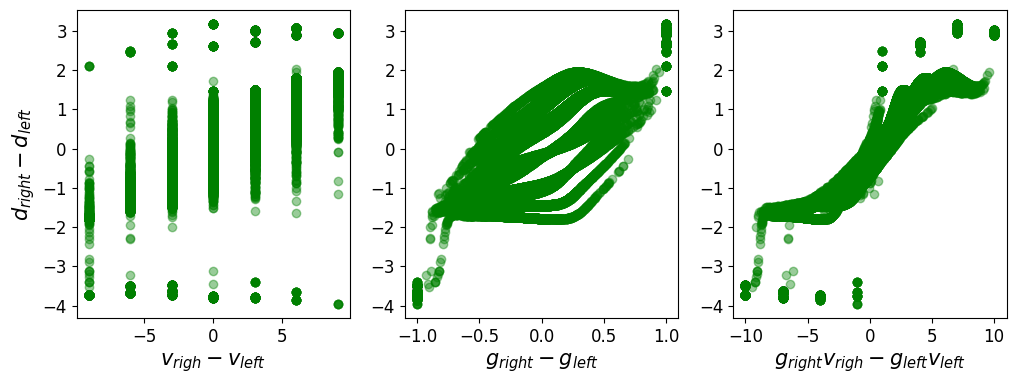

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 1] - X_test[:, 0], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 3] - X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 3] - X_test[:, 0]*X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

# plt.savefig('_plots/tv2017_complete_prmspred.pdf', 
#             dpi=600, 
#             transparent=True, 
#             bbox_inches='tight');